### Imports

In [1]:
import glob
import matplotlib.pyplot as plt
import multiprocessing as mp
import seaborn as sns
import numpy as np
# np.random.seed(42)
import os
import pandas as pd

from utils.loading import TICKER_PATHS, \
    PLT_PATH, \
    BUYER_PATH, \
    SELLER_PATH
from utils.loading import read_ticker
from utils.preprocessing import preprocess_ticker
from utils.processing import process_all_tickers, buyer_seller_stats

### Processing
---------
Below, we will be processing the data to get it ready for analysis. We will be doing the following:
- Extracting the price impact of each metaorder vs the volume of the metaorder
- Saving the data to a parquet file

This will be done in a multiprocessing fashion to speed up the process.

In [2]:
process_all_tickers(TICKER_PATHS)

ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/GCN.GO...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/IRC.CXC...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/KRS.ALP...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/SMM.GO...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/CFY.ALP...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/TE.ALP...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/LTG.ALP...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/WEY.V...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/GSW.GO...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/AGY.ALP...
ERROR:root:Error processing /Users/hamzezi/Desktop/FBD/FBD-Project/data/trade/HXC.ALP...
ERROR:root:Error processing

The error messages above indicate that the source `Ticker` is empty, and it will not be taken into account in the analysis. Let's load our data and see what's going on.

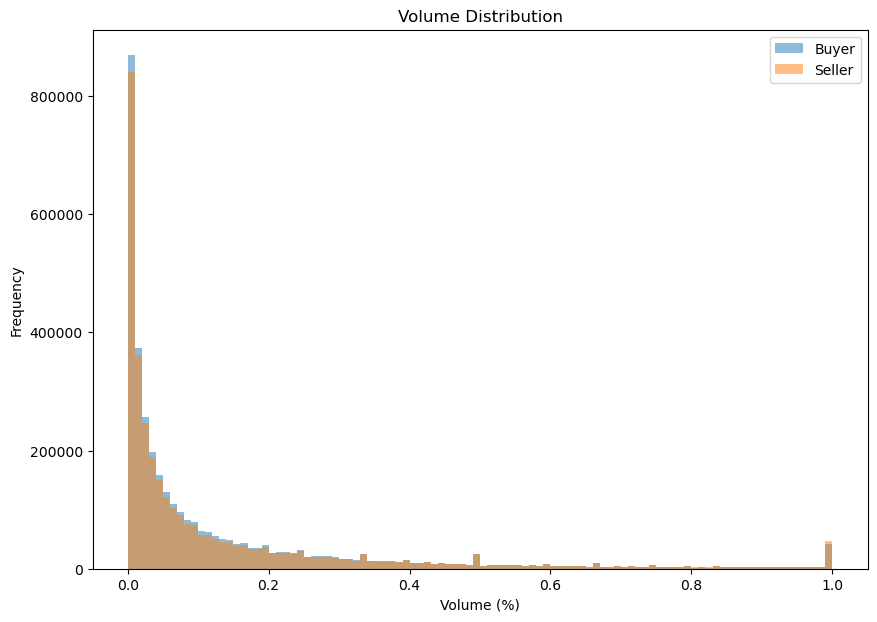

In [2]:
buyer_files = glob.glob(os.path.join(BUYER_PATH, "*.parquet"))
seller_files = glob.glob(os.path.join(SELLER_PATH, "*.parquet"))

df_buyer = pd.concat((pd.read_parquet(f) for f in buyer_files))
df_seller = pd.concat((pd.read_parquet(f) for f in seller_files))

plt.figure(figsize=(10, 7))
plt.hist(df_buyer["volume_pct"], bins=100, label="Buyer", alpha=0.5)
plt.hist(df_seller["volume_pct"], bins=100, label="Seller", alpha=0.5)
plt.legend()
plt.xlabel("Volume (%)")
plt.ylabel("Frequency")
plt.title("Volume Distribution")
plt.savefig(os.path.join(PLT_PATH, "volume_dist.png"))
plt.show();

As we can see, the volume distribution is very skewed, with a few metaorders having a percentage of the total volume of more than 50%. This is a problem because it will skew our analysis. We will therefore remove the metaorders with a volume of more than 10% of the total volume. We will still plot them in a separate graph to see if there is anything interesting going on.

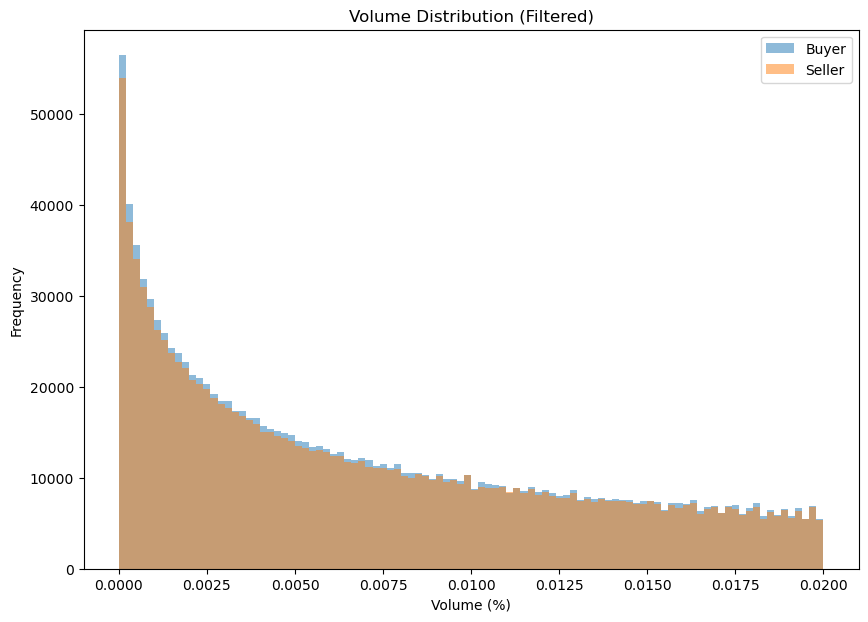

In [3]:
VOLUME_PCT_THRESHOLD = 0.02
df_buyer_filtered = df_buyer[(df_buyer["volume_pct"] < VOLUME_PCT_THRESHOLD)].copy()
df_seller_filtered = df_seller[df_seller["volume_pct"] < VOLUME_PCT_THRESHOLD].copy()

plt.figure(figsize=(10, 7))
plt.hist(df_buyer_filtered["volume_pct"], bins=100, label="Buyer", alpha=0.5)
plt.hist(df_seller_filtered["volume_pct"], bins=100, label="Seller", alpha=0.5)
plt.legend()
plt.xlabel("Volume (%)")
plt.ylabel("Frequency")
plt.title("Volume Distribution (Filtered)")
plt.savefig(os.path.join(PLT_PATH, "volume_dist_filtered.png"))
plt.show();

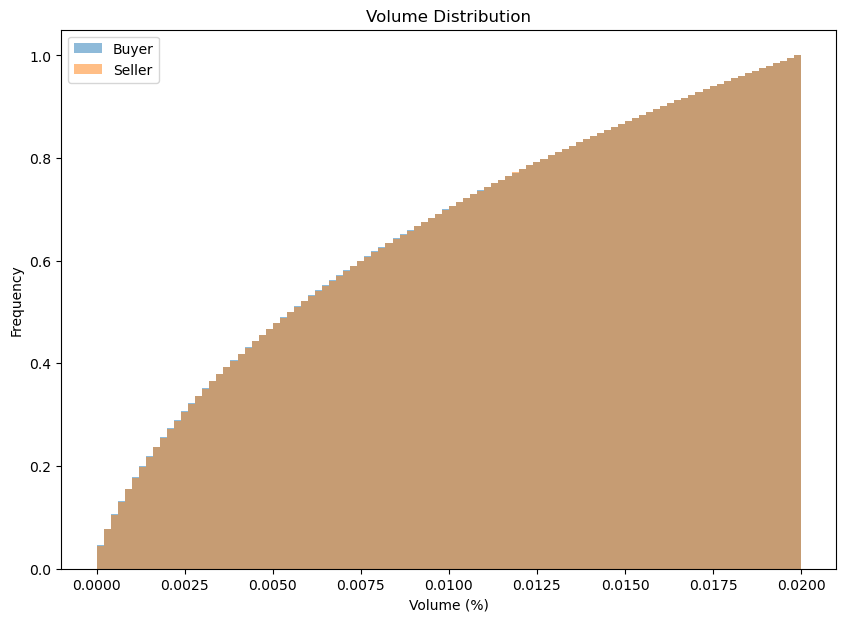

In [4]:
# plot volume ccdf
plt.figure(figsize=(10, 7))
plt.hist(df_buyer_filtered["volume_pct"],
         bins=100,
         label="Buyer",
         alpha=0.5,
         cumulative=True,
         density=True)
plt.hist(df_seller_filtered["volume_pct"],
         bins=100,
         label="Seller",
         alpha=0.5,
         cumulative=True,
         density=True)
plt.legend()
plt.xlabel("Volume (%)")
plt.ylabel("Frequency")
plt.title("Volume Distribution")
plt.savefig(os.path.join(PLT_PATH, "volume_dist_ccdf.png"))
plt.show();

In [5]:
def volume_bins(df: pd.DataFrame, num_bins = 150):
    df = df.copy()
    volume_bins = pd.qcut(df['volume_pct'], q=num_bins, duplicates='drop')
    binned_data = df.groupby(volume_bins,
                             observed=False)['price_impact_pct']\
                                .mean()\
                                .reset_index(name='avg_price_impact')
    binned_data['volume_pct'] = binned_data['volume_pct'].apply(lambda x: x.mid)
    return binned_data

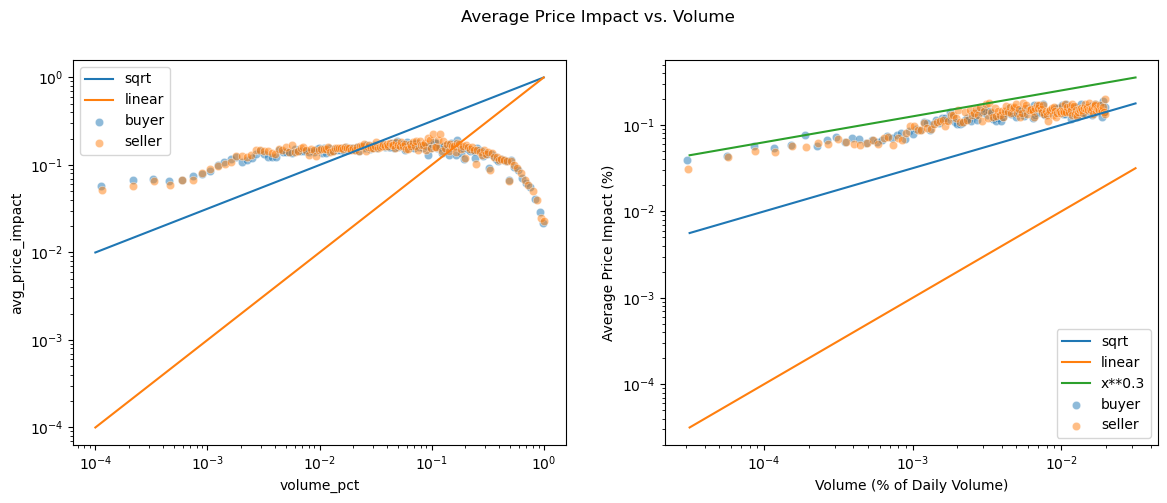

In [6]:
buyer_binned = volume_bins(df_buyer)
seller_binned = volume_bins(df_seller)
buyer_binned_filtered = volume_bins(df_buyer_filtered)
seller_binned_filtered = volume_bins(df_seller_filtered)

x = np.logspace(-4, 0, 10_000)
y_sqrt = np.sqrt(x)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.loglog(x, y_sqrt, label='sqrt')
ax1.loglog(x, x, label='linear')
sns.scatterplot(x='volume_pct',
                y='avg_price_impact',
                data=buyer_binned,
                alpha=0.5,
                ax=ax1,
                label='buyer')
sns.scatterplot(x='volume_pct',
                y='avg_price_impact',
                data=seller_binned,
                alpha=0.5,
                ax=ax1,
                label='seller')
x = np.logspace(-4.5, -1.5, 10_000)
y_sqrt = np.sqrt(x)
ax2.loglog(x, y_sqrt, label='sqrt')
ax2.loglog(x, x, label='linear')
ax2.loglog(x, x**0.3, label='x**0.3')
sns.scatterplot(x='volume_pct',
                y='avg_price_impact',
                data=buyer_binned_filtered,
                alpha=0.5,
                ax=ax2,
                label='buyer')
sns.scatterplot(x='volume_pct',
                y='avg_price_impact',
                data=seller_binned_filtered,
                alpha=0.5,
                ax=ax2,
                label='seller')
fig.suptitle("Average Price Impact vs. Volume")
# ax2.title("Unfiltered volume")
# ax2.("Filtered volume")
plt.xlabel("Volume (% of Daily Volume)")
plt.ylabel("Average Price Impact (%)")
plt.savefig(os.path.join(PLT_PATH, "price_impact_vs_volume.png"))
plt.show();